In [1]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.Requirement already satisfied: setuptools in c:\users\hp\appdata\local\programs\python\python311\lib\site-packages (from tensorflow-intel==2.13.0->tensorflow) (67.6.1)

  Obtaining dependency information for MarkupSafe>=2.1.1 from https://files.pythonhosted.org/packages/be/bb/08b85bc194034efbf572e70c3951549c8eca0ada25363afc154386b5390a/MarkupSafe-2.1.3-cp311-cp311-win_amd64.whl.metadata
  Using cached MarkupSafe-2.1.3-cp311-cp311-win_amd64.whl.metadata (3.1 kB)
Using cached MarkupSafe-2.1.3-cp311-cp311-win_amd64.whl (17 kB)
  Attempting uninstall: MarkupSafe
    Found existing installation: MarkupSafe 2.0.1
    Uninstalling MarkupSafe-2.0.1:
      Successfully uninstalled MarkupSafe-2.0.1


In [2]:
import tensorflow as tf  #open source library for machine learning
from tensorflow.keras import models,layers  
import matplotlib.pyplot as plt

In [3]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3


In [4]:
#loads the data from the hard drive or cloud space to the RAM in batches and generates a tf.data.Dataset spatial data structure(tensor)
#objects that can be used to train the models
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "training_images",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 3619 files belonging to 5 classes.


In [5]:
#classifying the data into five classes and '0','1','2','3'and '4' as class names that represents the 
# severity in DR 
class_names=dataset.class_names
class_names

['0', '1', '2', '3', '4']

In [6]:
#gives the total length of the dataset which are divided into the batches of 32 images each (114*32=3648)
len(dataset)

114

In [7]:
#visualization of the data which is loaded into the RAM
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")
    


In [8]:
 # 80%==>training
    # 20%==>testing(10%==>validation , 10%==>testing)

In [9]:
#function to split the dataset into the train,test and validation dataset

def get_dataset_partition_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
        ds_size=len(ds)
        if shuffle:
            ds=ds.shuffle(shuffle_size,seed=12)
        train_size=int(train_split*ds_size)
        val_size=int(val_split*ds_size)
        train_ds=ds.take(train_size)
        val_ds=ds.skip(train_size).take(val_size)
        test_ds=ds.skip(train_size).skip(val_size)
        
        return train_ds,test_ds,val_ds
    
    
    

In [10]:
#fuction calling to split the dataset 
train_ds,val_ds,test_ds=get_dataset_partition_tf(dataset)

In [11]:
len(train_ds)
print(type(train_ds))

<class 'tensorflow.python.data.ops.take_op._TakeDataset'>


In [12]:
len(test_ds)

11

In [13]:
len(val_ds)


12

In [14]:
#cache basically improves the performance of the tensorflow input pipeline 
#prefetch loads the next set of file from the disk 
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


In [15]:
#Since the original dataset is imbalanced(have different dimensions ) 
#we need to resize the images into the same dimensions and also rescale the images 
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [16]:
#data augmentation to create variations in the existing dataset 
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    
    
])

In [17]:
#combining all the layers to create a training model
input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes=5
model=models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax'),#softmax normalizes the probability of the classes
])
model.build(input_shape=input_shape)

In [18]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [19]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [20]:
#the network is actually trained here
history=model.fit(
    train_ds,
    epochs=28,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds

)

Epoch 1/28
91/91 [==============================] - 552s 4s/step - loss: 1.2637 - accuracy: 0.4825 - val_loss: 0.9697 - val_accuracy: 0.4986
Epoch 2/28
91/91 [==============================] - 235s 3s/step - loss: 1.0251 - accuracy: 0.6056 - val_loss: 0.9248 - val_accuracy: 0.6704
Epoch 3/28
91/91 [==============================] - 241s 3s/step - loss: 0.8847 - accuracy: 0.6937 - val_loss: 0.8381 - val_accuracy: 0.7324
Epoch 4/28
91/91 [==============================] - 226s 2s/step - loss: 0.8438 - accuracy: 0.7020 - val_loss: 0.7753 - val_accuracy: 0.7437
Epoch 5/28
91/91 [==============================] - 231s 3s/step - loss: 0.8581 - accuracy: 0.6941 - val_loss: 0.7581 - val_accuracy: 0.7380
Epoch 6/28
91/91 [==============================] - 231s 3s/step - loss: 0.8132 - accuracy: 0.7055 - val_loss: 0.7524 - val_accuracy: 0.7268
Epoch 7/28
91/91 [==============================] - 227s 2s/step - loss: 0.8010 - accuracy: 0.7055 - val_loss: 0.7309 - val_accuracy: 0.7352
Epoch 8/28
91

In [21]:
scores = model.evaluate(test_ds) 

11/11 [==============================] - 161s 672ms/step - loss: 0.5821 - accuracy: 0.8011


In [22]:
history.params


{'verbose': 1, 'epochs': 28, 'steps': 91}

In [23]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [24]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']



In [25]:
#plot between the number of epochs and trainingand validation accuracy 
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(28),acc,label='Training Accuracy')
plt.plot(range(28),val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

Text(0.5, 1.0, 'Training and Validation Accuracy')

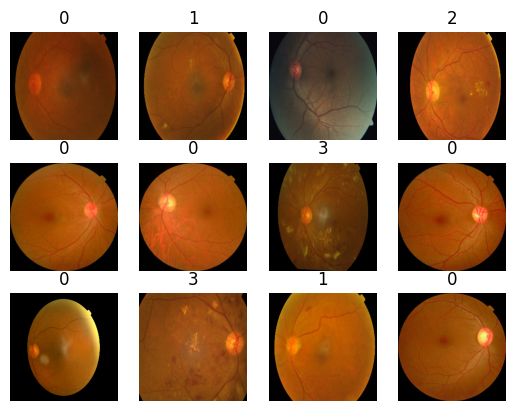

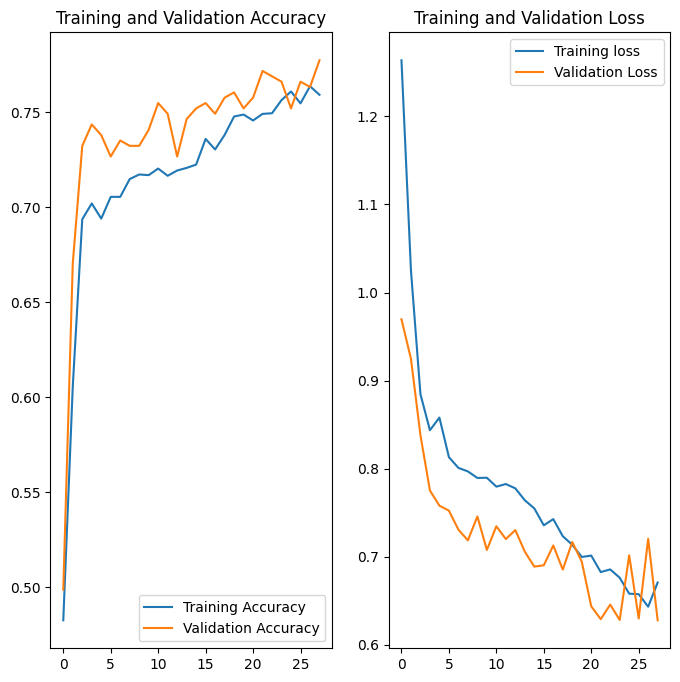

In [26]:
plt.subplot(1,2,2)
plt.plot(range(28),loss,label='Training loss')
plt.plot(range(28),val_loss,label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [27]:
#model prediction 
import numpy as np
for images_batch , labels_batch in test_ds.take(1):
    first_image=images_batch[0].numpy().astype('uint8')
    first_label=labels_batch[0].numpy()
    
    print("First image to predict")
    plt.imshow(first_image)
    print("Actual label:",class_names[first_label])
    
    batch_prediction=model.predict(images_batch)
    print("Predicted Label :",class_names[np.argmax(batch_prediction[0])])
    

First image to predict
Actual label: 2
1/1 [==============================] - 2s 2s/step
Predicted Label : 2


In [28]:
def predict(model,img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0) #create a batch

    predictions=model.predict(img_array)
    predicted_class=class_names[np.argmax(predictions[0])]
    confidence=round(100*(np.max(predictions[0])),5)
    return predicted_class ,confidence


In [29]:
plt.figure(figsize=(10,10))
for images ,labels in test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class,confidence=predict(model,images[i].numpy())
        actual_class=class_names[labels[i]]
        plt.title(f"Actual:{actual_class},\n Predicted:{predicted_class}.\n Confidence:{confidence}%")
        plt.axis("off")
    

1/1 [==============================] - 0s 110ms/step


In [30]:
import os

model_version=max([int(i) for i in os.listdir("../models")+[0]])+1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/3\assets


INFO:tensorflow:Assets written to: ../models/3\assets
